# Chinese document Classification

In [1]:
from argparse import Namespace

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm_notebook

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 6)

### Args for this task

In [20]:
args = Namespace(
    zhnews_csv="data/zhnews.csv",
    batch_size=32,
    num_epochs=100,
    cuda=True,
)

args.cuda = args.cuda and torch.cuda.is_available()

if args.cuda:
    print("CUDA is enabled")
else:
    print("CUDA is not enabled")

CUDA is enabled


# Overview of Task

## 1. Load data

In [3]:
data = pd.read_csv(args.zhnews_csv, names=['label', 'title', 'content'])
data.head()

,label,title,content
0,1,ti3 ca1o shi4 jie4 be1i : che2ng fe1i na2 pi2...,su4 du4 : ( shuo1 mi2ng : dia3n ji1 zi4 do4ng ...
1,4,da3o ha2ng,du2 jia1 ti2 go1ng me3i ri4 ba4o jia4 \n re4 ...
2,1,wa3ng yi4 ti3 yu4,gu3n do4ng tu2 ji2 \n be3n tu2 ji2 go4ng 7 zh...
3,3,zi1 lia4o tu2 pia4n : dia4n shi4 ju4 < fu2 gu...,wa3ng ye4 \n bu4 zhi1 chi2 Flash\n xi1n la4n...
4,2,niu3 yua2n dui4 me3i yua2n : ku4 lu2n jia3ng ...,xi1n xi1 la2n ca2i cha2ng ku4 lu2n fa1 bia3o j...


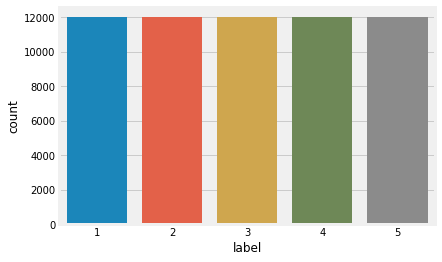

In [4]:
sns.countplot(data['label'])

## 2. Build vocab

In [5]:
chars = 'abcdefghijklmnopqrstuvwxyz-,;!?:\'\\|_@#$%ˆ&*˜‘+-=<>()[]{} '
char_to_index = {char:i for i, char in enumerate(chars)}
index_to_char = {i: char for i, char in enumerate(chars)}

## 3. Find max sequence length

In [6]:
maxlen = int(max(data['title'].apply(len)))
maxlen

207

## 4. Convert sequences to Tensors

In [7]:
def encode_input(title, maxlen=207):
    title = title.lower().strip()
    encoding = np.zeros((len(chars), maxlen), dtype=np.int64)
    for i, char in enumerate(title[:maxlen]):
        index = char_to_index.get(char, 'unknown')
        if index is not 'unknown':
            encoding[index,i] = 1
    return encoding

In [8]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [9]:
encode_input('Brian')

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
encode_input('Brian').shape

(57, 207)

## 5. Build PyTorch Dataset and DataLoader

In [11]:
from torch.utils.data import Dataset, DataLoader

In [12]:
class SogouNews(Dataset):
    """Sogou News dataset"""
    
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path, names=['label', 'title', 'content']).dropna()
        del self.data['content']
        self.X = self.data['title']
        self.y = self.data['label']
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        content = torch.from_numpy(encode_input(self.data['title'][index])).float()
        label = self.data['label'][index] - 1
        sample = {'x_content': content, 'y_label': label}
        return sample

In [13]:
sogou_dataset = SogouNews(args.zhnews_csv)

In [14]:
dataloader = DataLoader(sogou_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0)

In [15]:
test_batch = next(iter(dataloader))
test_batch['x_content'][0]


    0     1     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 57x207]

# Define Model

In [16]:
class CharCNN(nn.Module):    
    def __init__(self, n_classes, vocab_size, max_seq_length, channel_size=128, pool_size=5):
        
        super(CharCNN, self).__init__()
    
        self.conv_stack = nn.ModuleList([nn.Conv1d(vocab_size, channel_size, 7), 
                                         nn.ReLU(),
                                         nn.BatchNorm1d(num_features=channel_size),
                                         nn.MaxPool1d(pool_size),
                                         nn.Conv1d(channel_size, channel_size, 3, padding=1),
                                         nn.ReLU(),
                                         nn.BatchNorm1d(num_features=channel_size),
                                         nn.MaxPool1d(pool_size)])
        self.dropout1 = nn.Dropout(p=0.5)
        self.output = nn.Linear(1024, n_classes)
        
        
    def forward(self, x):
        for op in self.conv_stack:
            x = op(x)
        
        x = x.view(x.size(0),-1)
        x = self.dropout1(x)
        x = self.output(x)
        return x

## Training Routine

In [17]:
classifier = CharCNN(n_classes=5, vocab_size=len(chars), max_seq_length=maxlen)

In [23]:
if args.cuda:
    classifier = classifier.cuda()

optimizer = torch.optim.Adam(classifier.parameters())
criterion = nn.CrossEntropyLoss()

loss_history = []
accuracy_history = []

epoch_bar = tqdm_notebook(desc='epochs')
batch_bar = tqdm_notebook(desc='batches', total=len(data)//args.batch_size)

try:

    for _ in range(args.num_epochs):
        per_epoch_losses = []
        per_epoch_accuracy = []
        for batch in dataloader:
            # Step 1: clear the gradients 
            optimizer.zero_grad()

            # Step 2: apply the model to the data
            x_content = Variable(batch['x_content'])
            y_label = Variable(batch['y_label'])
            if args.cuda:
                x_content = x_content.cuda()
                y_label = y_label.cuda()

            y_prediction = classifier(x_content)

            # Step 3: compute the loss and propagate the gradients
            loss = criterion(y_prediction, y_label)
            loss.backward()

            per_epoch_losses.append(loss.data[0])
            
            accuracy = np.mean(y_prediction.cpu().data.numpy().argmax(axis=-1)==y_label.cpu().data.numpy())
            per_epoch_accuracy.append(accuracy)

            # Step 4; have optimizer update the model weights
            optimizer.step()
            
            batch_bar.update()

        loss_history.append(np.mean(per_epoch_losses))
        accuracy_history.append(np.mean(per_epoch_accuracy))
        epoch_bar.set_postfix(loss=loss_history[-1], accuracy=accuracy_history[-1])
        epoch_bar.update()
        batch_bar.n = 0
        
except KeyboardInterrupt:
    pass

HBox(children=(IntProgress(value=1, bar_style='info', description='epochs', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='batches', max=1875), HTML(value='')))

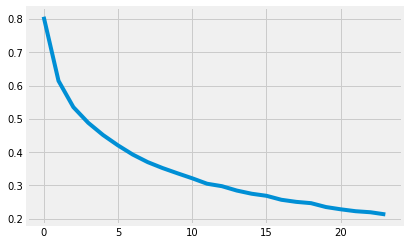

In [24]:
plt.plot(loss_history);